# Multiple Linear Regression

For this model we will apply more than one variable to the model to try and more accurately predict saleprice.

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Loading the cleaned data
train = pd.read_csv('../datasets/train_cleaned.csv')
test = pd.read_csv('../datasets/test_cleaned.csv')

<Axes: >

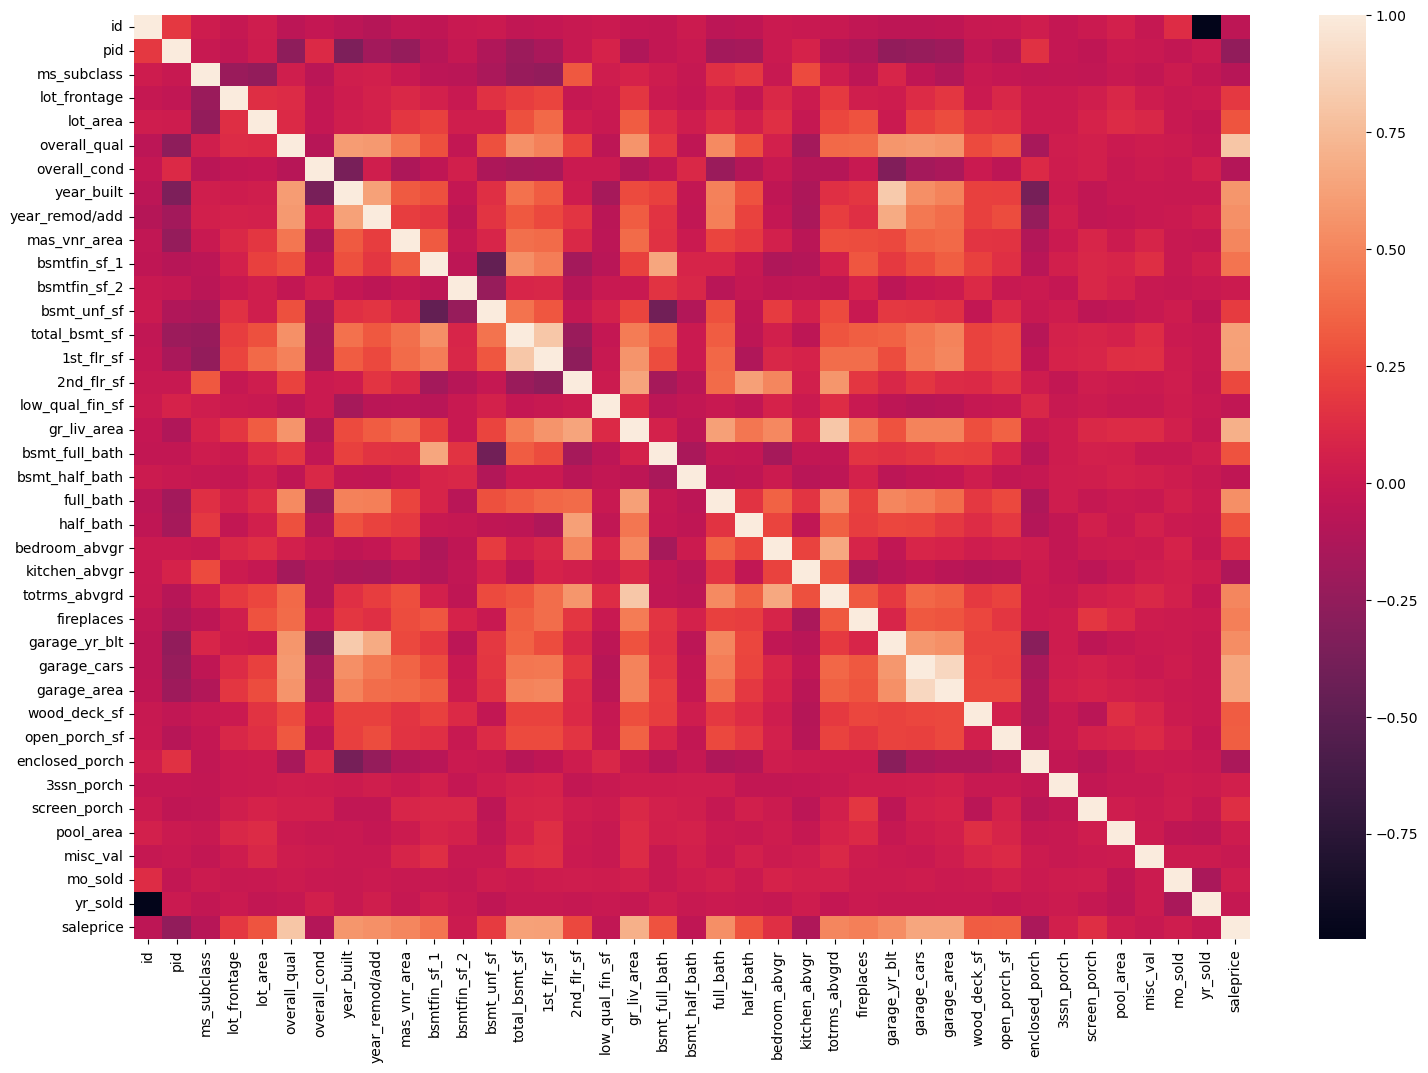

In [7]:
# Correlation heat map to determine what variable to use.
corr = train.corr(numeric_only=True)
plt.figure(figsize=(18, 12))
sns.heatmap(corr)

#### Feature Engineering

Lets feature engineer a couple variables. I would like to make a new variable age that is yr_sold minus year_built. this will show us the age of the home when bought. Another thing is total_bath that is full_bath plus half_bath*0.5 plus bsmt_full_bath + bsmt_half_bath*0.5.

In [10]:
# Age
train['age'] = train['yr_sold'] - train['year_built']
test['age'] = test['yr_sold'] - test['year_built']

# Remodel Age
train['remodel_age'] = train['yr_sold'] - train['year_remod/add']
test['remodel_age'] = test['yr_sold'] - test['year_remod/add']

In [11]:
# Total_bath
train['total_bath'] = (train['full_bath'] + 
                       train['half_bath'] * 0.5 + 
                       train['bsmt_full_bath'] + 
                       train['bsmt_half_bath'] * 0.5)
                       
test['total_bath'] = (test['full_bath'] + 
                      test['half_bath'] * 0.5 + 
                      test['bsmt_full_bath'] + 
                      test['bsmt_half_bath'] * 0.5)

In [12]:
#tot_sqft
train['total_sf'] = train['total_bsmt_sf'] + train['1st_flr_sf'] + train['2nd_flr_sf'] + train['garage_area']
test['total_sf'] = test['total_bsmt_sf'] + test['1st_flr_sf'] + test['2nd_flr_sf'] + test['garage_area']

## Qualitative Relationships

To see the categorical variables and their relationship with sale price I will us box plots to visualize it.

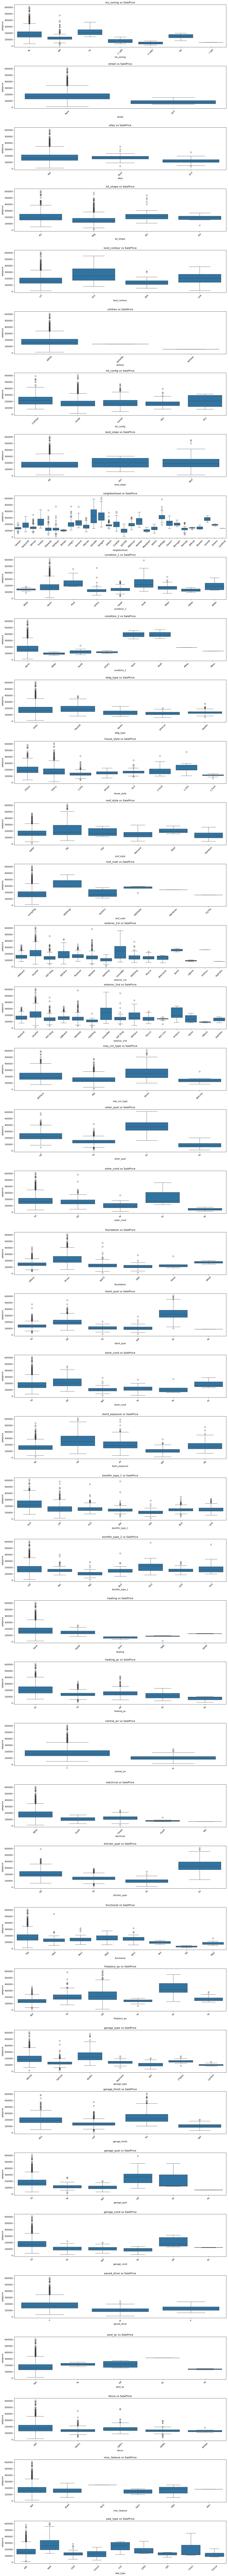

In [15]:
# Getting all categorical (object type) columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Creating the boxplots
plt.figure(figsize=(15, len(categorical_cols) * 4))

for i, col in enumerate(categorical_cols):
    plt.subplot(len(categorical_cols), 1, i + 1)
    sns.boxplot(x=train[col], y=train['saleprice'])
    plt.xticks(rotation=45)
    plt.title(f'{col} vs SalePrice')

plt.tight_layout()
plt.show()

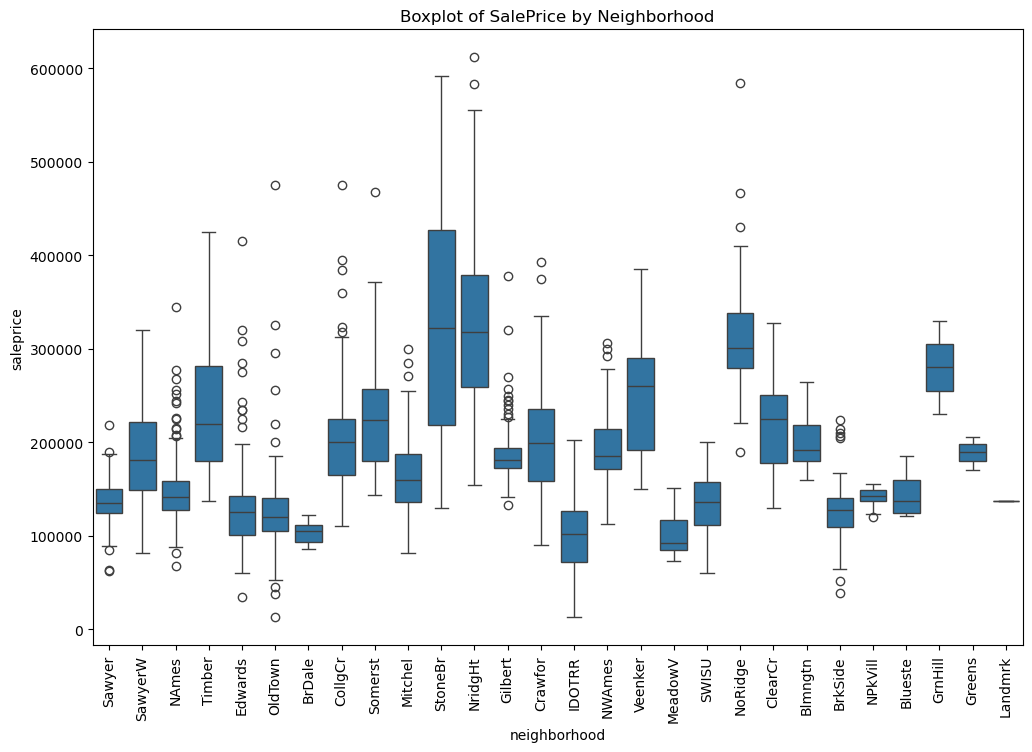

In [16]:
# Specifically looking a neighborhood box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='neighborhood', y='saleprice', data=train)
plt.xticks(rotation=90)
plt.title("Boxplot of SalePrice by Neighborhood")
plt.savefig('../images/qualitative_example.png', dpi=300, bbox_inches='tight')
plt.show()

When looking at these box plots I am looking for big shifts accross different categories to see how they affect saleprice. I am intereested in 4 categorical variables to add to my model. Nieghborhood, exterqual, condition1, exterior1st.

In [18]:
# one hot encoding
#train = pd.get_dummies(train, columns=['neighborhood', 'exter_qual', 'condition_1', 'exterior_1st'], drop_first=True, dtype=int)
#test = pd.get_dummies(test, columns=['neighborhood', 'exter_qual', 'condition_1', 'exterior_1st'], drop_first=True, dtype=int)

## One hot encoding categorical variables

In [20]:
train["is_train"] = 1
test["is_train"] = 0 

# Concatenating both datasets
all_data = pd.concat([train, test], axis=0)

# One-hot encoding categorical variables
all_data = pd.get_dummies(all_data, drop_first=True, dtype=int)

# Split them back using "is_train"
train = all_data[all_data["is_train"] == 1].drop(columns=["is_train"])
test = all_data[all_data["is_train"] == 0].drop(columns=["is_train"])


In [21]:
# I will save this new dataframe to make further enhancements in another notebook
train.to_csv('../datasets/train_dummies.csv', index=False)
test.to_csv('../datasets/test_dummies.csv', index=False)

Lets now fit the numerical variables and categorical ones into the model.

In [23]:
# Train test split
X = train[['overall_qual','age', 'total_bath', 'total_sf'] + [col for col in train.columns if 'neighborhood' in col] + [col for col in train.columns if 'exter_qual' in col] + [col for col in train.columns if 'fireplace_qu' in col] + [col for col in train.columns if 'kitchen_qual' in col]]
#X = train.drop(columns=['saleprice','garage_yr_blt'])
y = train['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Init and fitting model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [25]:
# Making the predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [26]:
# R squared of train
r2_score(y_train, y_train_pred)

0.8501160083606466

In [27]:
# RMSE of train
np.sqrt(mean_squared_error(y_train, y_train_pred))

30882.48770006605

In [28]:
# R sqaured of test
r2_score(y_test, y_test_pred)

0.8667365127470453

In [29]:
# RMSE of test
np.sqrt(mean_squared_error(y_test, y_test_pred))

28138.711311642604

**Try 1** This first try we used the variables  overall quality, gr_liv_area, garage_area, and year_built. Wow! A nice improvement. The train r2 score is 76.02 and rmse is 39060. the test r2 score is 80.67 percent and rmse of 33882. This tells us that mostlikely our model is not overfit however it may still be underfit we will tweak some variables and try to improve.

**Try 2** This try we feature engineered age, total_bath, and total_sf. We removed gr_living_area, garage_area, and year_built since they are already related to our features. The train r2 is 76.41 and rmse is 38737. The test r2 is 81.84 and rmse is 32841. this model is a slight improvememt and next we will see if adding qualitative variables can help boost it.

**Try 3** This try we added four categorical variables to our model. Neighborhood, exter_qual, condition1, and exterior_1st were added and our model imporved. the train r2 was 83.85 percent and rmse of 32056. the test r2 was 83.82 percent and rmse of 31004.

In [31]:
# predicting onto the kaggle test dataset.
preds = lr.predict(test[['overall_qual','age', 'total_bath', 'total_sf'] + [col for col in test.columns if 'neighborhood' in col] + [col for col in test.columns if 'exter_qual' in col] + [col for col in test.columns if 'fireplace_qu' in col] + [col for col in test.columns if 'kitchen_qual' in col]])

In [32]:
# fitting to kaggle format
submission = pd.DataFrame({'id': test['id']})
submission['saleprice'] = preds
submission.describe()

,id,saleprice
count,878.000000,878.000000
mean,1444.749431,178957.633138
std,850.838263,70192.141725
min,2.000000,42023.931148
25%,692.250000,128590.551607
50%,1433.000000,167871.215856
75%,2197.500000,213020.880530
max,2928.000000,507755.345750


In [33]:
submission.to_csv('../datasets/mlr_model_submission_3.csv', index=False)